# Getting Started with Transfer Learning Using Tensorflow Hub

### What is Transfer Learning?

**Transfer Learning** is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem

Transfer Learning overcomes the problem of isolated laerning by applying the knowledge gained during learning one task to another different but similar task. For example, knowledge gained while learning to recognize cars could be applied when trying to recognize trucks! The intuition actually came from the humans. We humans always practice *Transfer Learning*. A person who knows how to drive a bike, finds it easy to learn how to drive a car. Similarly *Transfer Learning* helps in learning difficult tasks with less effort.

### How Does TensorFlow Hub Help Us?

**TensorFlow Hub** is a repository of pre-trained machine learning models. These models are categorised in three broad problem domains - 
- Image
- Text
- Video

There are several models, which you can quickly start using without much hassle. Visit [TensorFlow Hub](https://tfhub.dev) for more details.

## The Problem

For the demonstration of the tranfer learning technique, I will be using the case of [this](https://www.kaggle.com/c/nlp-getting-started) competition. The goal here is to build a machine learning model which is able to predict whether a tweet belongs to a real disaster or not!

## Dataset

Dataset given here is tweets from different users split into training and test set. **target** is the dependent variable, which we are interested in predicting for the test set. Let's begin with our analysis.

## Step 0. Importing Libraries

In [7]:
# General Purpose Libraries
import numpy as np
np.random.seed(1)
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [8]:
# Text Processing Libraries
import spacy
import re
import string 
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swsong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
# Scikit Learn
from sklearn.model_selection import train_test_split

In [5]:
# TensorFlow
import tensorflow_hub as hub
import tensorflow as tf 
tf.random.set_seed(1)

In [9]:
# Setting Pandas Display Option
pd.set_option('display.max_colwidth', 500)

In [10]:
# Suppress warning
import warnings
warnings.filterwarnings('ignore')

## Step 1. Loading Data

Let's begin by loading the dataset in our environment and then take a peek at the dataset.

In [11]:
# Reading Data Files
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print('Train Shape : ', train.shape)
print('Test Shape : ', test.shape)

Train Shape :  (7613, 5)
Test Shape :  (3263, 4)


In [12]:
# Viewing top rows of training set
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [13]:
# Viewing top rows of test set
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


- There are 7612 rows and 5 columns in the training set.
- There are 3263 rows and 4 columns in the test set.
- **Target** is the dependent variable, with values 0 and 1 indicating a fake and real disaster tweet respectively.
- **id** is just an unique identifier of the tweet. Training and Test set are subsets of a sample of tweets collected.
- There are many missing values in **location** variable.

## Step 2. Basic EDA

Let's do some basic EDA to better understand the dataset provided.

### 2-a. Missing Values

In [14]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

**location** has many missing values. Are those missing values indicate non-legitimate tweets?

There might be some information here. We will look at it at a later stage.

### 2-b. The Dependent Variable - *target*

In [21]:
# Proportion of classes
print('Number of values : ')
print(train['target'].value_counts(), '\n')
print('Normalized Number of values : ')
print(train['target'].value_counts(normalize=True))

Number of values : 
0    4342
1    3271
Name: target, dtype: int64 

Normalized Number of values : 
0    0.57034
1    0.42966
Name: target, dtype: float64


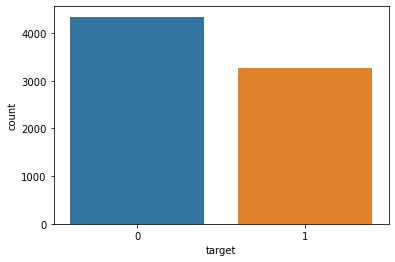

In [23]:
# Visualize the classes
sns.countplot('target', data=train);

### 2-c. Independent Variables

**Keyword**

In [25]:
# Unique Words Count
train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

There are 221 unique words present in training set. Some text cleaning is required here to extract some information from this variable.

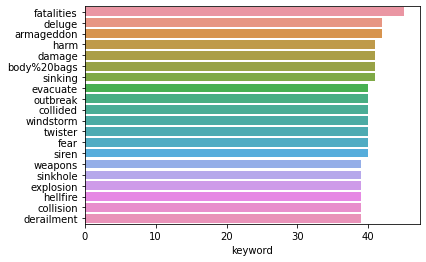

In [27]:
# Visualize top 20 keywords
sns.barplot(
    x=train['keyword'].value_counts()[:20],
    y=train['keyword'].value_counts()[:20].index
);

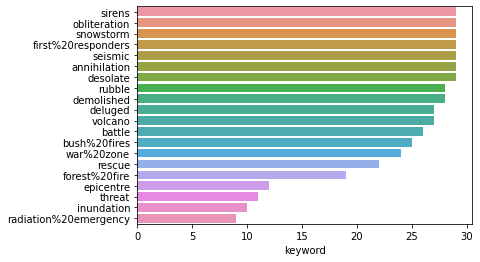

In [29]:
# Visualize bottom 10 keywords
sns.barplot(
    x=train['keyword'].value_counts()[-20:],
    y=train['keyword'].value_counts()[-20:].index);

**location**

In [30]:
# Unique Words Count
train.location.value_counts()

USA                             104
New York                         71
United States                    50
London                           45
Canada                           29
                               ... 
Fort Walton Beach, FL             1
Canada Eh!                        1
U.S.A. - Global Members Site      1
Alicante, Spain                   1
Somewhere in Jersey               1
Name: location, Length: 3341, dtype: int64

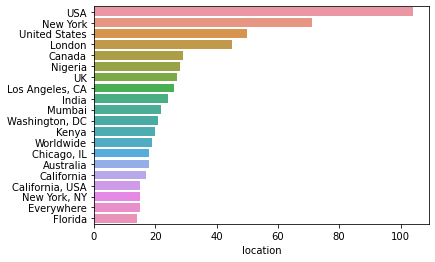

In [32]:
# Visualize top 20 locations
sns.barplot(
    x=train['location'].value_counts()[:20],
    y=train['location'].value_counts()[:20].index
);

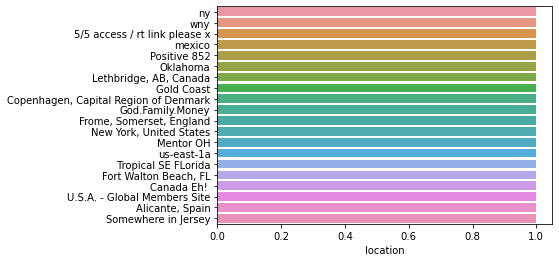

In [35]:
# Visualize bottom 20 locations
sns.barplot(
    x = train['location'].value_counts()[-20:],
    y = train['location'].value_counts()[-20:].index
);

There are many repetitions of location in the dataset with multiple names. For example - USA, United States & New York are separate entries. Also there are some numbers in this variable. We need to address these issues before making use to this variable in our model.

**text**

This is our main variable which contains actual tweets from different users. Let's take a look at some random tweets to get a sense of how the data is and what kind of pre-processing is required.

In [37]:
train['text'].sample(5)

3228    Goulburn man Henry Van Bilsen missing: Emergency services are searching for a Goulburn man who disappeared from hisÛ_ http://t.co/z99pKJzTRp
3706       The things we fear most in organizations--fluctuations disturbances imbalances--are the primary sources of creativity. - Margaret Wheatley
6957                                                                                                                          @tsunami_esh ?? hey Esh
2887     @POTUS you until you drown by water entering the lungs. You being alive has caused this great country to fall to shit because you're a pussy
7464                                                                                              Crawling in my skin\nThese wounds they will not hea
Name: text, dtype: object

As one can expect from any textual data, there are all sorts of messyness going on here. There are numbers, special characters, links, punctuation marks etc. present in the tweets. We need to clean these before we proceed with modeling, in order to get good results.

Now, Let's see how a typical "Real" & "Not Real" tweet looks like.

In [38]:
# Real tweets indicating disaster
real_tweets = train[train['target']==1]['text']
real_tweets.values[0:5]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

## Step 3. Text Preprocessing

### 3-a. Text Cleaning

Let's begin our text preprocessing by creating a custom function to remove numbers, links, punctuations etc. The following function has been taken from [Parul Pandey](https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro)'s notebook.

In [43]:
# Custom Function for Text Cleaning

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [44]:
# Applying the cleaning function to both test and training datasets
train['cleaned_text'] = train['text'].apply(lambda x : clean_text(x))
test['cleaned_text'] = test['text'].apply(lambda x : clean_text(x))

# Take a look at the cleaned text
train['cleaned_text'].head()

0                                                                  our deeds are the reason of this earthquake may allah forgive us all
1                                                                                                 forest fire near la ronge sask canada
2    all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3                                                                             people receive wildfires evacuation orders in california 
4                                                just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
Name: cleaned_text, dtype: object

### **3-b. Removing Stopwords**

Simplyremoving all stopwords from the text might lead to loss of semantic meaning of the sentences. Since, we intend to use models which capture the semantic meaning tis important that we take care of this problem. We will be using nlppreprocess library from PyPI to remove only unwanted stopwords.

In [45]:
!pip install nlppreprocess

In [46]:
from nlppreprocess import NLP

nlp = NLP()
train['stopwords_cleaned'] = train['cleaned_text'].apply(nlp.process)
test['stopwords_cleaned'] = test['cleaned_text'].apply(nlp.process)

### 3-c. Lemmatization

Lemmatization is a technique where a word is reduced to its base or dictionary form. Like - Go, Going & Gone will all be relaced by Go. Let's create a custom function to lemmatize our tweets.

In [91]:
# Import spaCy's language model
en_model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
#en_model = spacy.load("en_core_web_sm")
# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in en_model(i)]
        output.append(' '.join(s))
    return output

In [92]:
# Applying the lemmatization function to both test and training datasets
train['lemmatized_text'] = lemmatization(train['stopwords_cleaned'])
test['lemmatized_text'] = lemmatization(test['stopwords_cleaned'])

In [93]:
# Let's take a look at the cleaned & lemmatized text
train.head(5)

,id,keyword,location,text,target,cleaned_text,stopwords_cleaned,lemmatized_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,our deeds are reason earthquake may allah forgive us,our deed be reason earthquake may allah forgive we
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,residents asked shelter in place are being notified by officers no evacuation shelter in place orders are expected,resident ask shelter in place be be notify by officer no evacuation shelter in place order be expect
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,people receive wildfires evacuation orders in california,people receive wildfires evacuation orders in california,people receive wildfire evacuation order in california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,just got sent photo from ruby alaska smoke from wildfires pours into school,just get send photo from ruby alaska smoke from wildfire pour into school


In [94]:
test.head(5)

,id,keyword,location,text,cleaned_text,stopwords_cleaned,lemmatized_text
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash,just happened terrible car crash,just happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",heard about earthquake is different cities stay safe everyone,heard about earthquake different cities stay safe everyone,hear about earthquake different city stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",there is a forest fire at spot pond geese are fleeing across the street i cannot save them all,there forest fire spot pond geese are fleeing across street cannot save them,there forest fire spot pond geese be flee across street can not save they
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfires,apocalypse light spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan,typhoon soudelor kills in china and taiwan,typhoon soudelor kill in china and taiwan


I have added three new variab les to our training and testing set so that we can test which strategy is producing best results.

## Step 4. Wordcloud

Let's visualize wordcloud for train and test set to see the distribution of words!

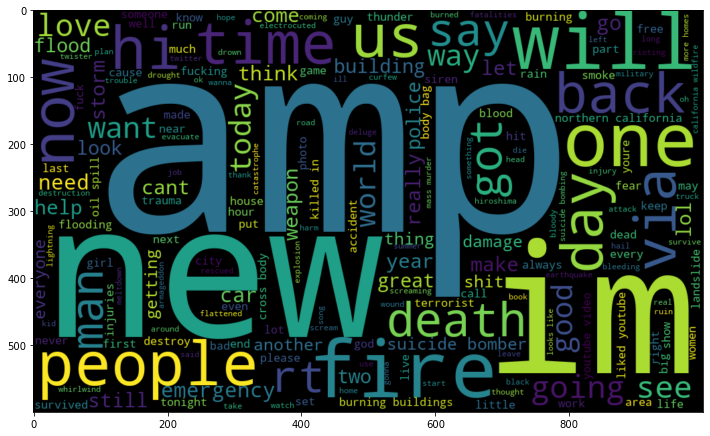

In [97]:
# Wordcloud for train set
plt.figure(figsize=(12,9))
wordcloud = WordCloud(min_font_size=6, max_words=200, width=1000, height=600).generate(" ".join(train['stopwords_cleaned']))
plt.imshow(wordcloud, interpolation='bilinear');

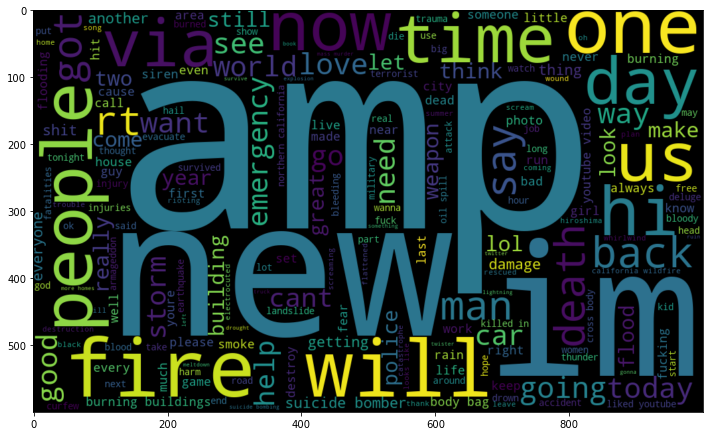

In [99]:
# Wordcloud for test set
plt.figure(figsize=(12,9))
wordcloud = WordCloud(min_font_size=6, max_words=200, width=1000, height=600).generate(" ".join(train['stopwords_cleaned']))
plt.imshow(wordcloud, interpolation='bilinear');

Some additional efforts required in cleaning the tweets to achieve better accuracy. Nonetheless, let's move to modeling and see how good our model is.

## Step 5. Modeling Using Pretrained Model

I will be using [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4) for modeling. It encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. There are two variations of this model on *TensorFlow Hub* -
- Deep Averaging Network (DAN) Encoder.
- Transformer Encoder.

I will be using the one with DAN architecture, since it is computationally less intensive. We will download this model as a *KerasLayer* and use it as input layer for our Keras Sequential Model.

### 5-a. Creating Training & Testing Set

I will be using **stopwords_cleaned** variable for training our classification model, as it produced better results than the other text variables.

In [100]:
# Splitting training & test set
X_train, X_test, y_train, y_test = train_test_split(train['stopwords_cleaned'], train['target'], test_size=0.2, random_state=1)

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [103]:
# Build a Keras Sequential Model using Pre-trained Universal Sentence Encoder as the Input Layer
hub_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    input_shape=[],
    output_shape=[512],
    dtype = tf.string,
    trainable=True
)

model = Sequential([
    hub_layer,
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 256,867,649
Trainable params: 256,867,649
Non-trainable params: 0
_________________________________________________________________
